# Test

### Imports

In [8]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, plot_test_results, cross_entropy_loss_method, predict, accuracy_func
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam
from Code.data_handling import load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

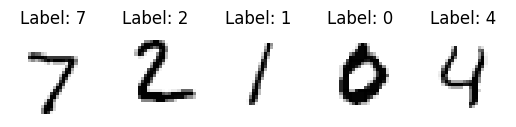

In [9]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)

# Display some images
for i, image in enumerate(X_test[0:5]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    n = int((image.shape[0])**(1/2))
    plt.imshow(image.reshape(n,n), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {np.argmax(y_test[i])}")
plt.show()

### Training the neural network

In [10]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, hidden_layer_num, node_per_hidden, 
               hidden_activation, output_activation=softmax,
               epochs=300, batches=5,
               plot_or_not=False, result_filepath=None):
    
    """
    Performs a training with the given parameter

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    layer_list = [X_train.shape[1]] + [node_per_hidden]*hidden_layer_num + [y_train.shape[1]]
    beta0 = _beta_init(layer_list)
    model = jit(get_neural_network_model(hidden_layer_num,activation=hidden_activation,
                                         output_activation=output_activation))

    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    # loss_func = jit(ridge_loss_method(model=model, lam=lam))
    loss_func = jit(cross_entropy_loss_method(model=model, lam=lam))   
    loss_grad = jit(grad(loss_func))
    loss_func_name = "CE"

    # MSE loss function for evaluation
    test_func = jit(MSELoss_method(model))
    test_func = loss_func

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, n_batches=batches,
                      test_loss_func= test_func, lr=lr)

    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], 5, ylabel="MSE")

    # Add accuracy scores
    result["test_accuracy"]  = accuracy_func(model, result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_func(model, result["beta_final"], X_train, y_train)

    # Also store the model for later use
    result["model"] = model

    if result_filepath:
        _list_to_store = [{"test_accuracy"     : result["test_accuracy"], 
                           "train_accuracy"    : result["train_accuracy"],
                           "lr"                : lr, 
                           "lam"               : lam,
                           "epochs"            : epochs,
                           "batches"           : batches,
                           "hidden_layer_num"  : hidden_layer_num, 
                           "node_per_hidden"   : node_per_hidden, 
                           "hidden_activation" : hidden_activation.__name__,
                           "output_activation" : output_activation.__name__,
                           "loss_function"     : loss_func_name}]
        print(_list_to_store)
        append_run_to_file(result_filepath, _list_to_store)

    return result

# epochs = 5
# batches = 30
# result = single_run(X_train, X_test, y_train, y_test, 
#                     lr=0.01, lam=0.0001, hidden_layer_num=5, 
#                     node_per_hidden=40, hidden_activation=nn.sigmoid, 
#                     epochs=epochs, batches=batches,
#                     plot_or_not=True, result_filepath="test.json")

# print("test: ", result["test_accuracy"])
# print("train: ", result["train_accuracy"])

# print("MSE test: ", result["test_loss_list"][-1])
# print("MSE train: ", result["train_loss_list"][-1])

100%|██████████| 50/50 [03:52<00:00,  4.65s/it]


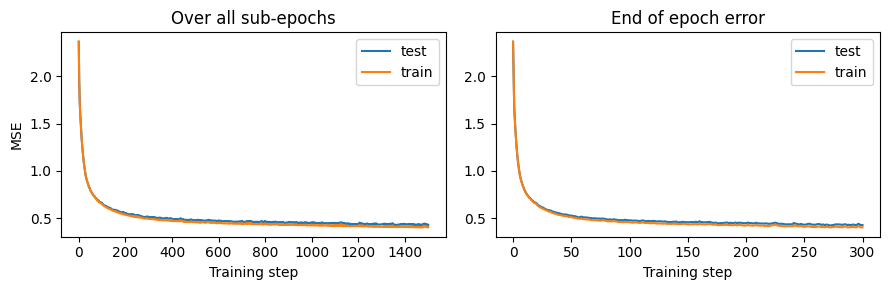

[{'test_accuracy': 0.8833000063896179, 'train_accuracy': 0.8902333378791809, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 1, 'node_per_hidden': 5, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:49<00:00,  4.60s/it]


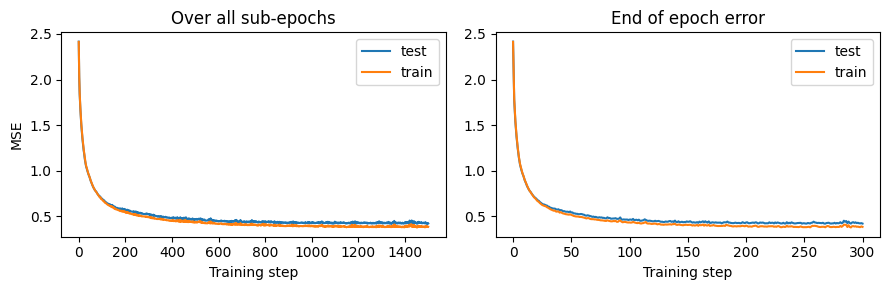

[{'test_accuracy': 0.8894000053405762, 'train_accuracy': 0.8982499837875366, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 2, 'node_per_hidden': 5, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:47<00:00,  4.55s/it]


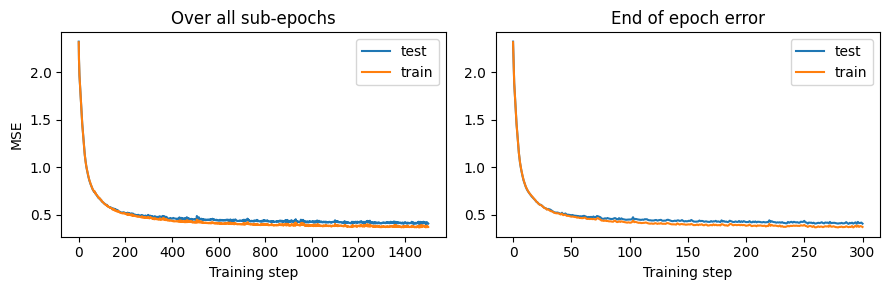

[{'test_accuracy': 0.8996999859809875, 'train_accuracy': 0.9065333604812622, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 3, 'node_per_hidden': 5, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:53<00:00,  4.66s/it]


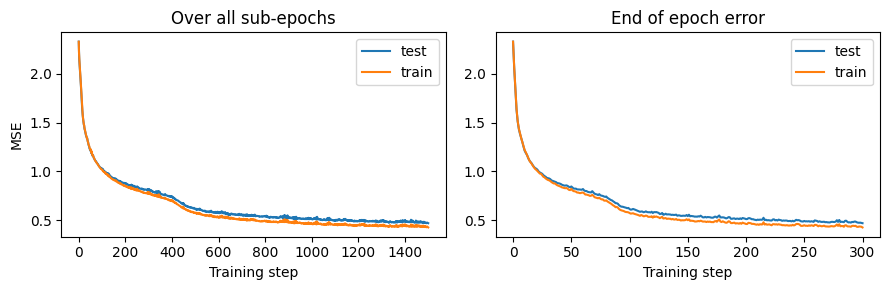

[{'test_accuracy': 0.8738999962806702, 'train_accuracy': 0.8884666562080383, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 4, 'node_per_hidden': 5, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:55<00:00,  4.71s/it]


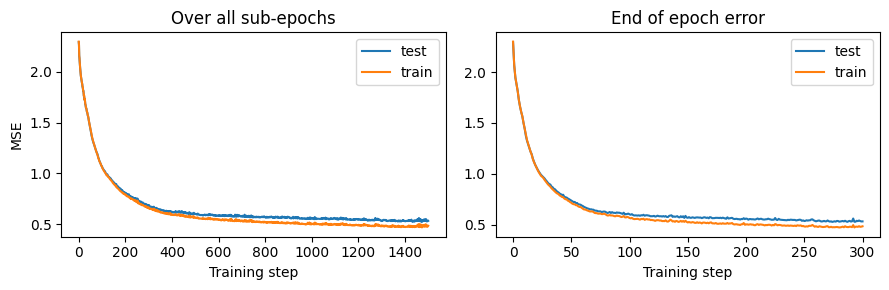

[{'test_accuracy': 0.8615999817848206, 'train_accuracy': 0.8756999969482422, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 5, 'node_per_hidden': 5, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:54<00:00,  4.69s/it]


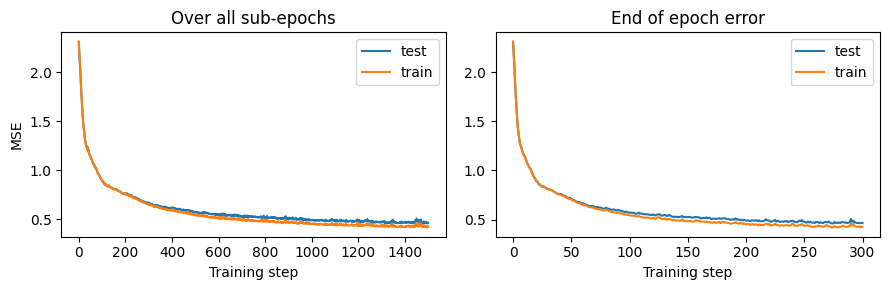

[{'test_accuracy': 0.8852999806404114, 'train_accuracy': 0.8962166905403137, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 6, 'node_per_hidden': 5, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:47<00:00,  4.55s/it]


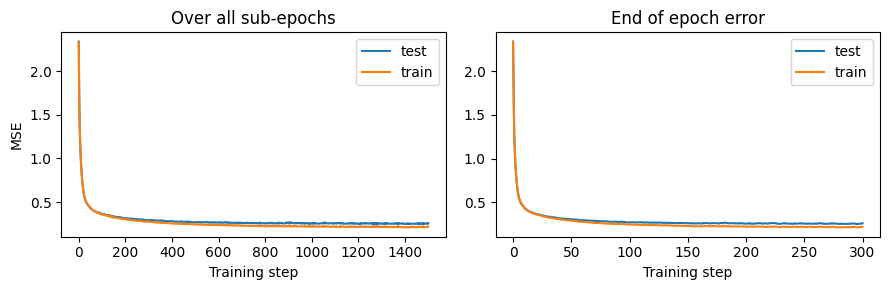

[{'test_accuracy': 0.9395999908447266, 'train_accuracy': 0.9472333192825317, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 1, 'node_per_hidden': 10, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:48<00:00,  4.57s/it]


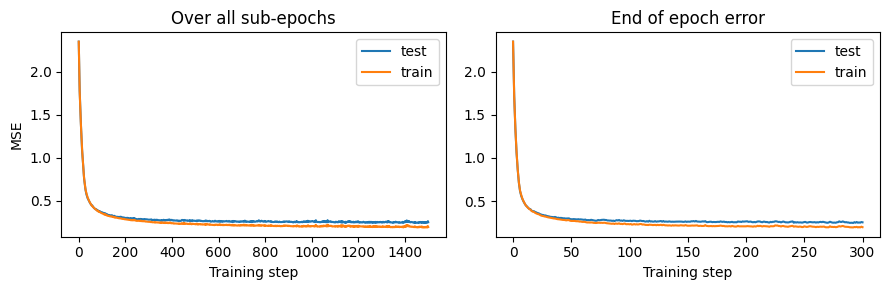

[{'test_accuracy': 0.9370999932289124, 'train_accuracy': 0.9524833559989929, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 2, 'node_per_hidden': 10, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:51<00:00,  4.64s/it]


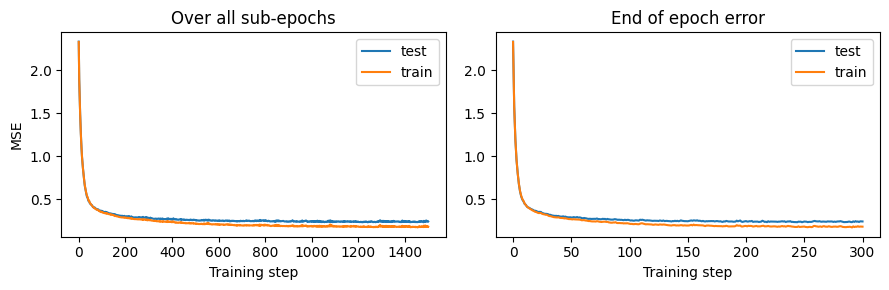

[{'test_accuracy': 0.9391000270843506, 'train_accuracy': 0.9563666582107544, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 3, 'node_per_hidden': 10, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:01<00:00,  4.83s/it]


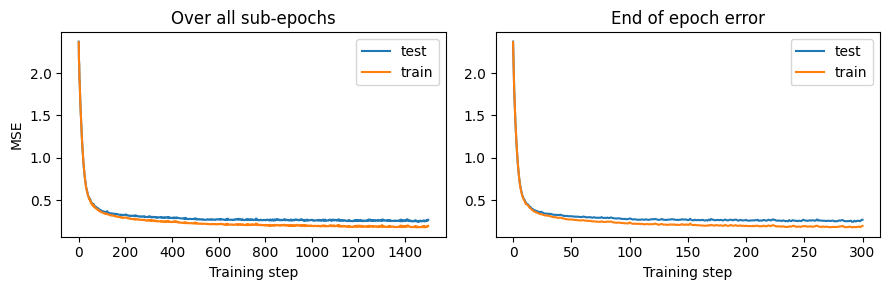

[{'test_accuracy': 0.9320999979972839, 'train_accuracy': 0.9505333304405212, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 4, 'node_per_hidden': 10, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:52<00:00,  4.64s/it]


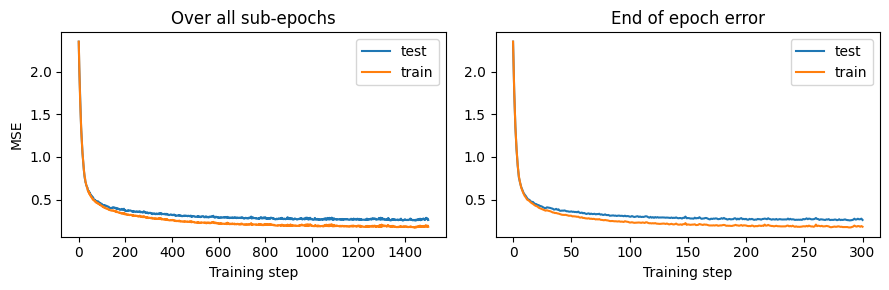

[{'test_accuracy': 0.9391000270843506, 'train_accuracy': 0.958299994468689, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 5, 'node_per_hidden': 10, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:59<00:00,  4.79s/it]


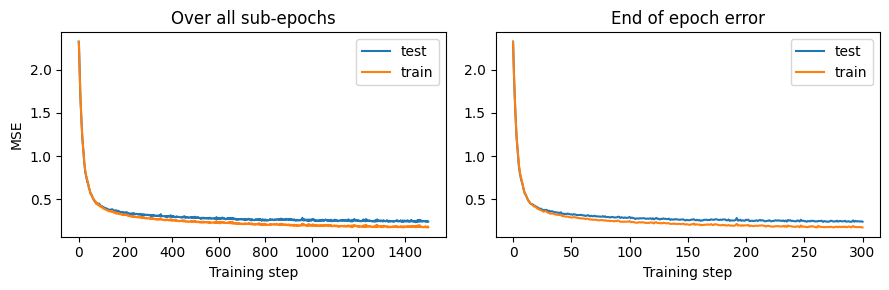

[{'test_accuracy': 0.9429000020027161, 'train_accuracy': 0.9592833518981934, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 6, 'node_per_hidden': 10, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:51<00:00,  4.64s/it]


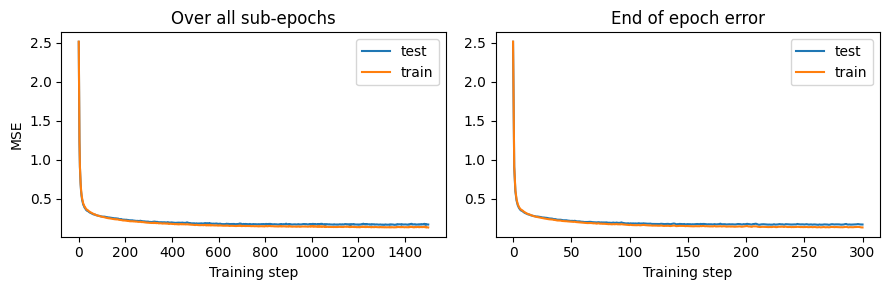

[{'test_accuracy': 0.9613000154495239, 'train_accuracy': 0.9756666421890259, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 1, 'node_per_hidden': 20, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:56<00:00,  4.72s/it]


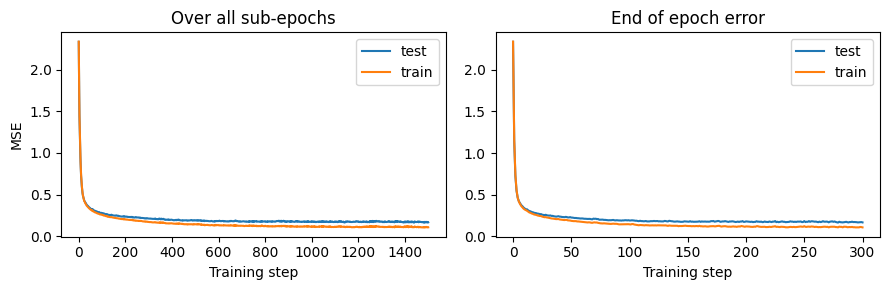

[{'test_accuracy': 0.9623000025749207, 'train_accuracy': 0.9814833402633667, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 2, 'node_per_hidden': 20, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:55<00:00,  4.71s/it]


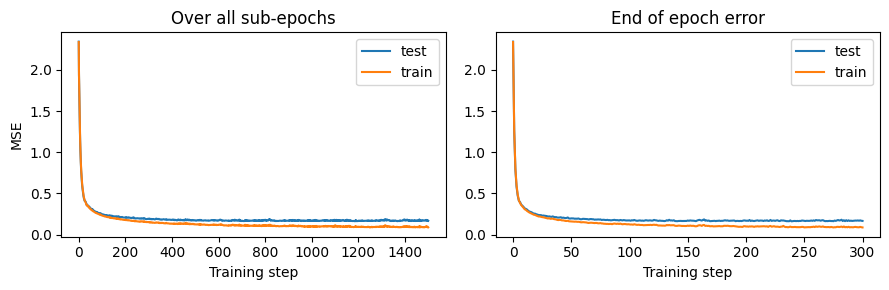

[{'test_accuracy': 0.9631999731063843, 'train_accuracy': 0.9855166673660278, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 3, 'node_per_hidden': 20, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:05<00:00,  4.90s/it]


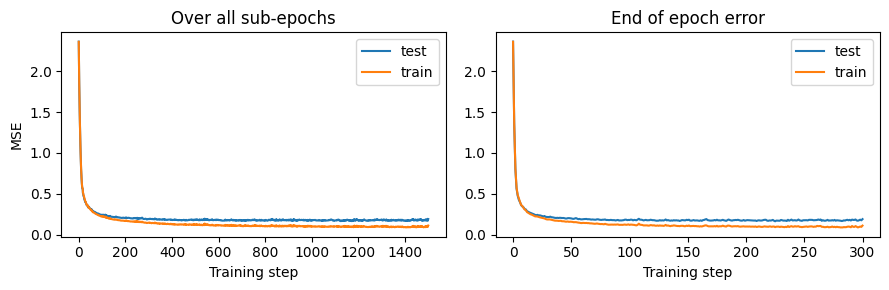

[{'test_accuracy': 0.9577999711036682, 'train_accuracy': 0.9767333269119263, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 4, 'node_per_hidden': 20, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:04<00:00,  4.89s/it]


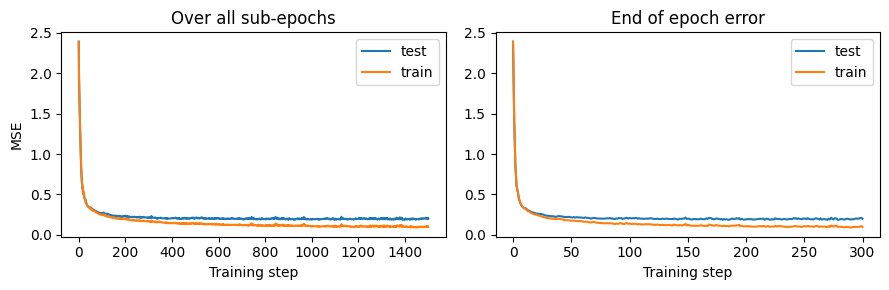

[{'test_accuracy': 0.9587000012397766, 'train_accuracy': 0.9828500151634216, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 5, 'node_per_hidden': 20, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:06<00:00,  4.93s/it]


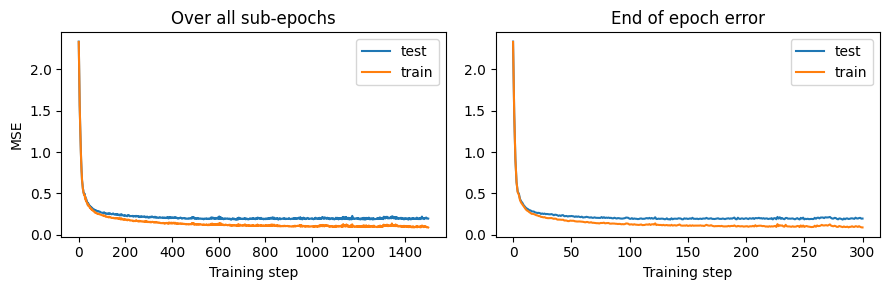

[{'test_accuracy': 0.9592000246047974, 'train_accuracy': 0.9867833256721497, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 6, 'node_per_hidden': 20, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [03:58<00:00,  4.78s/it]


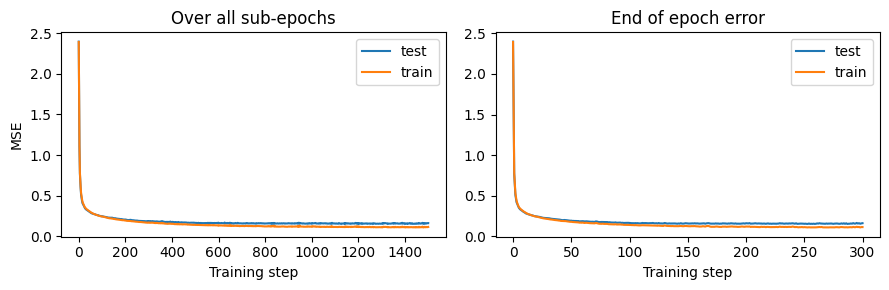

[{'test_accuracy': 0.9663000106811523, 'train_accuracy': 0.9815666675567627, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 1, 'node_per_hidden': 30, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:05<00:00,  4.91s/it]


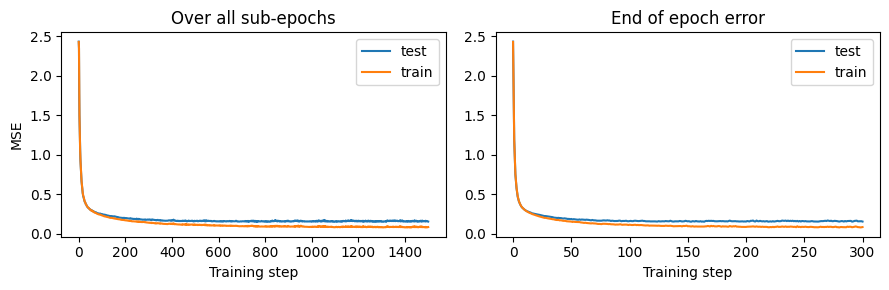

[{'test_accuracy': 0.967199981212616, 'train_accuracy': 0.9880499839782715, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 2, 'node_per_hidden': 30, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:12<00:00,  5.04s/it]


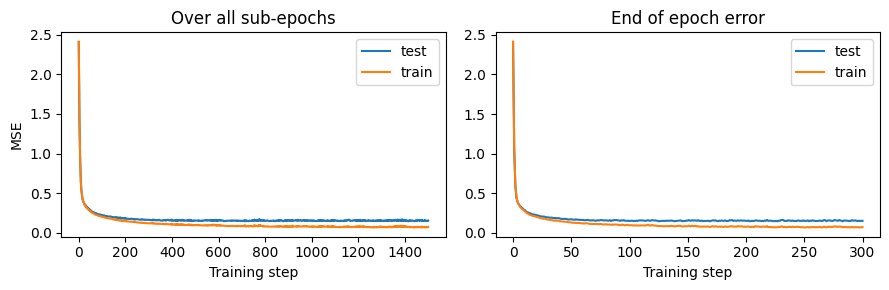

[{'test_accuracy': 0.9700999855995178, 'train_accuracy': 0.991183340549469, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 3, 'node_per_hidden': 30, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:14<00:00,  5.09s/it]


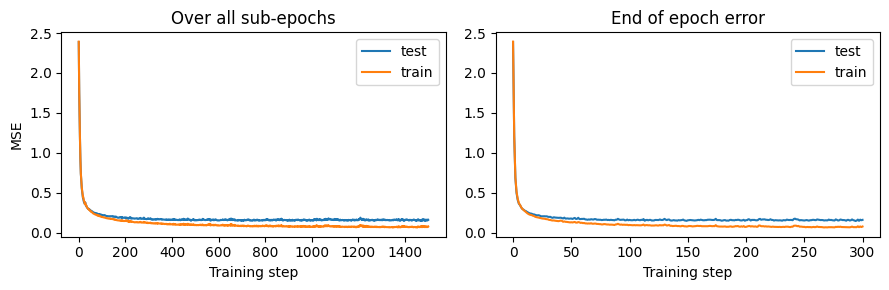

[{'test_accuracy': 0.9675999879837036, 'train_accuracy': 0.9886000156402588, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 4, 'node_per_hidden': 30, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:20<00:00,  5.22s/it]


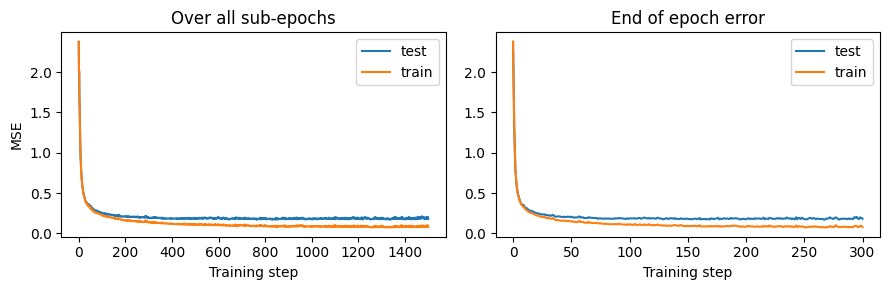

[{'test_accuracy': 0.9627000093460083, 'train_accuracy': 0.9890833497047424, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 5, 'node_per_hidden': 30, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:25<00:00,  5.31s/it]


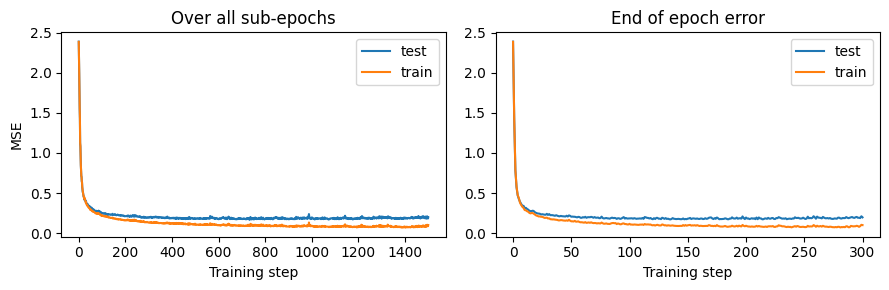

[{'test_accuracy': 0.9607999920845032, 'train_accuracy': 0.9816166758537292, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 6, 'node_per_hidden': 30, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:11<00:00,  5.03s/it]


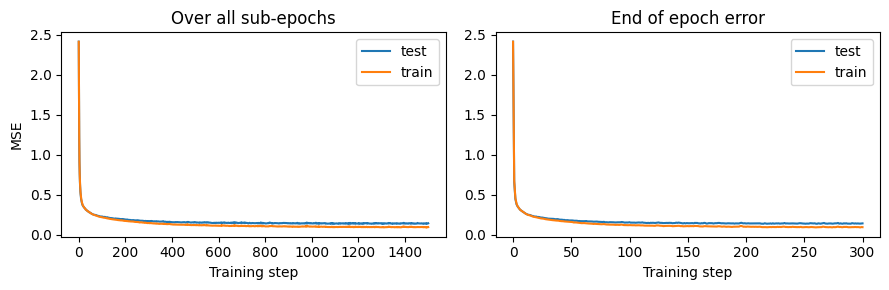

[{'test_accuracy': 0.9714999794960022, 'train_accuracy': 0.9879999756813049, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 1, 'node_per_hidden': 40, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:22<00:00,  5.24s/it]


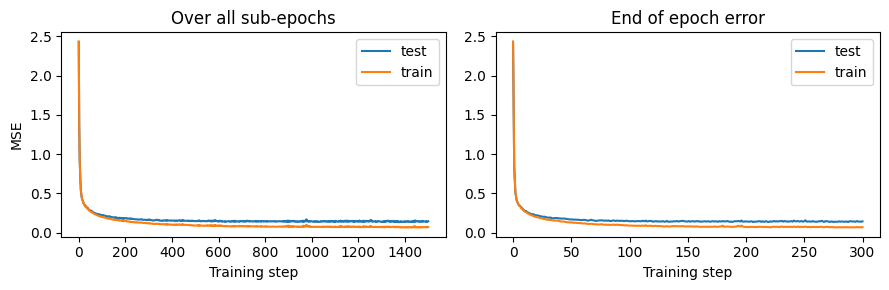

[{'test_accuracy': 0.9710999727249146, 'train_accuracy': 0.9922333359718323, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 2, 'node_per_hidden': 40, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:22<00:00,  5.25s/it]


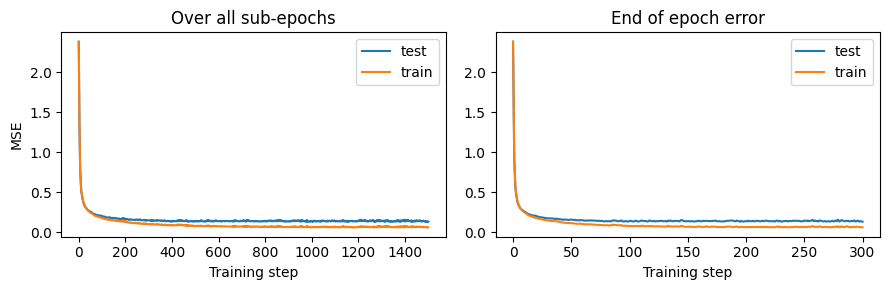

[{'test_accuracy': 0.9731000065803528, 'train_accuracy': 0.9944166541099548, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 3, 'node_per_hidden': 40, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:28<00:00,  5.36s/it]


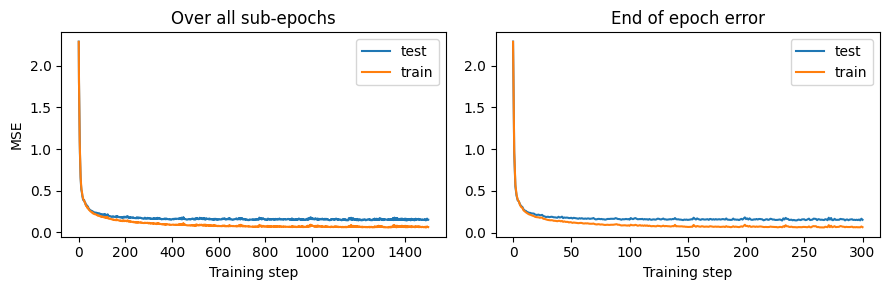

[{'test_accuracy': 0.9711999893188477, 'train_accuracy': 0.993149995803833, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 4, 'node_per_hidden': 40, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


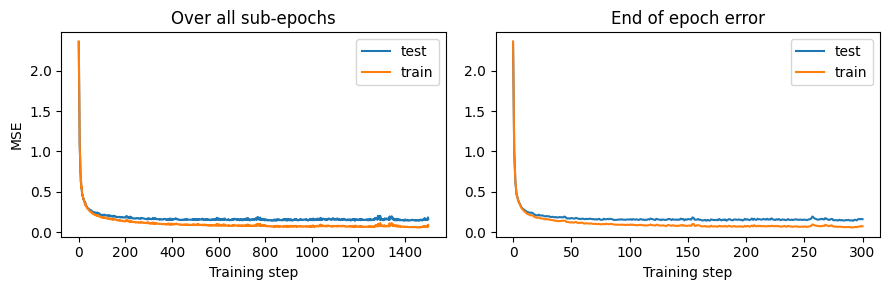

[{'test_accuracy': 0.9696000218391418, 'train_accuracy': 0.9913166761398315, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 5, 'node_per_hidden': 40, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:27<00:00,  5.35s/it]


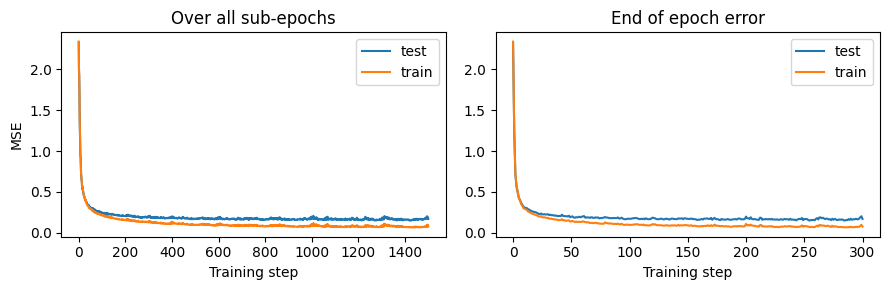

[{'test_accuracy': 0.9700000286102295, 'train_accuracy': 0.9910666942596436, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 6, 'node_per_hidden': 40, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


100%|██████████| 50/50 [04:32<00:00,  5.45s/it]


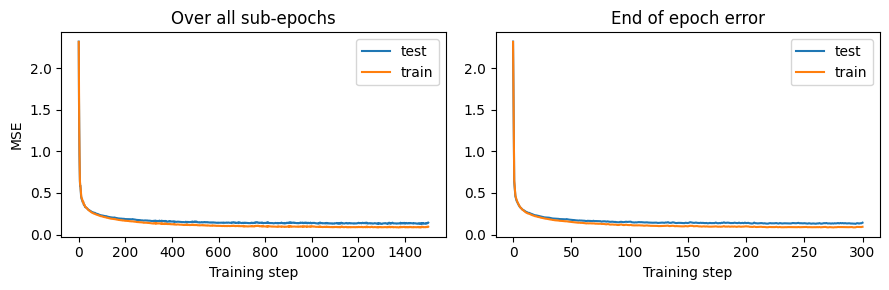

[{'test_accuracy': 0.972000002861023, 'train_accuracy': 0.9880499839782715, 'lr': 0.01, 'lam': 0.0001, 'epochs': 50, 'batches': 30, 'hidden_layer_num': 1, 'node_per_hidden': 50, 'hidden_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'CE'}]


 22%|██▏       | 11/50 [01:12<04:17,  6.61s/it]


KeyboardInterrupt: 

In [11]:
epochs = 50
batches = 30

for node_per_hidden in [5, 10, 20, 30, 40, 50]:
    for hidden_layer_num in [1, 2, 3, 4, 5, 6]:
        result = single_run(X_train, X_test, y_train, y_test, 
                            lr=0.01, lam=0.0001, hidden_layer_num=hidden_layer_num, 
                            node_per_hidden=node_per_hidden, hidden_activation=nn.tanh, 
                            epochs=epochs, batches=batches,
                            plot_or_not=True, result_filepath="grid.json")

In [ ]:
print(result["model"](result["beta_final"], X_train[0]))
print(y_train[0])

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

### Architecture

In [ ]:
def hidden_node_hidden_layer_grid(savefig=False, nreps=5):
    lam = 1e-5
    lr = 0.01
    hidden_activation = nn.tanh
    hidden_activation_name = "tanh"
    
    # Maximal number of hidden layers and nodes
    n = 6
    # m = 19
    m = 60
    
    filename = filepath_location + f"lr={lr}_lambda={lam}_hidden_activation_func={hidden_activation_name}_nreps={nreps}__hidden_layer_num_grid_experiment_classification.png"

    fig, ax = plt.subplots(figsize=(9, 9))

    hidden_layer_numbers = np.arange(1, n + 1)
    nodes_per_layer_list = np.arange(1, m, m//n)

    # Arrays for storing the errors. temporary result to call result.get
    test_errs_all = np.zeros(shape=(n, n))
    train_errs_all = np.zeros(shape=(n, n))
    result = {}

    # Loop over nodes per layer
    for i, nodes_per_layer in enumerate(nodes_per_layer_list):
        print(f"nodes per layer: {nodes_per_layer}")
        
        # Loop over number of hidden layers
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
        
            # Accumulation variables for averaging over nreps
            s_test = 0.0
            s_train = 0.0
        
            # Run nreps times 
            for k in range(nreps):
                result = single_run(X, y, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, 
                                    node_per_hidden=nodes_per_layer, hidden_activation=hidden_activation, 
                                    test_index=result.get("test_index"))
                s_test += result["test_accuracy"]
                s_train += result["train_accuracy"]

            test_errs_all[i, j] = s_test/nreps
            train_errs_all[i, j] = s_train/nreps


    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis", cbar=True)

    # Title
    ax.set_title("Final test accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Number of nodes per layer")

    ax.set_yticklabels(nodes_per_layer_list)
    ax.set_xticklabels(hidden_layer_numbers)
    

    plt.tight_layout()
    if savefig:
        fig.savefig(filename)
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}

_ = hidden_node_hidden_layer_grid(savefig=True, nreps=1)

NameError: name 'filepath_location' is not defined

### Final model evaluation

We make confusion matrix ...

In [ ]:
epochs = 300
result = single_run(X, y, lr=0.01, lam=0.0001, hidden_layer_num=5, node_per_hidden=40, 
           hidden_activation=nn.sigmoid, epochs=epochs, test_index=test_index, plot_or_not=True)

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("MSE test: ", result["test_loss_list"][0][-1])
print("MSE train: ", result["train_loss_list"][0][-1])


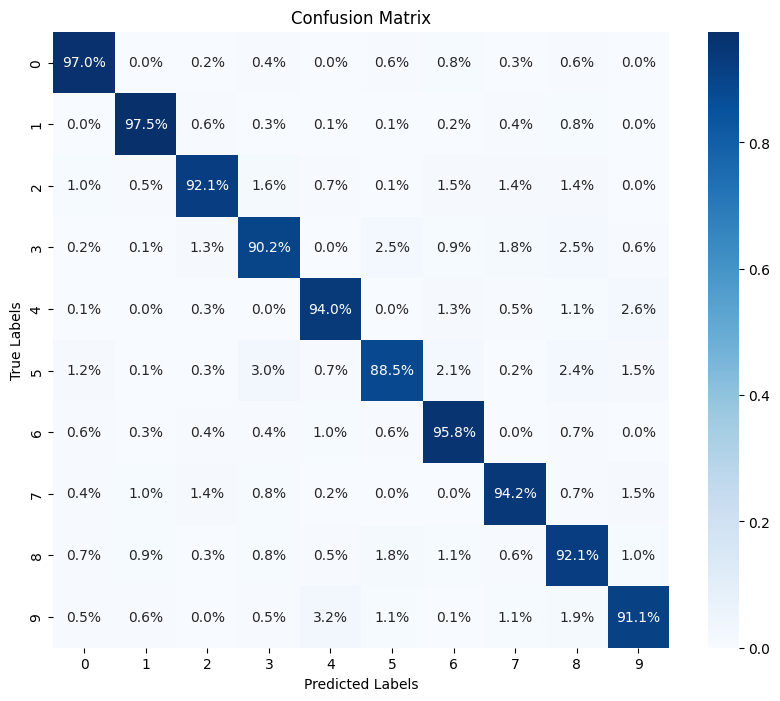

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Example true labels and predicted labels
nums_pred = predict(result["model"], result["beta_final"], X_test)
nums_gt   = jnp.array([jnp.argmax(y_sample) for y_sample in y_test])

# Create confusion matrix
conf_matrix = confusion_matrix(nums_gt, nums_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".1%", cmap="Blues", square=True,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Also want to see exactly where the model fails ...

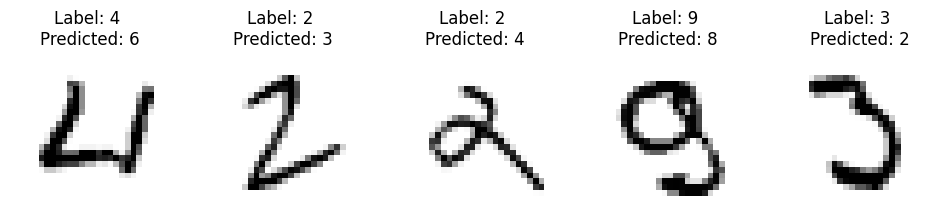

In [ ]:
# Format the faulty predictions back
indeces = nums_gt != nums_pred
imgs = [img.reshape(28, 28) for img in X_test[indeces]]
labels_pred = nums_pred[indeces]
labels_gt   = nums_gt[indeces]

# Plot the 5 first
for i, img in enumerate(imgs[0:5]):

    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {labels_gt[i]} \nPredicted: {labels_pred[i]}")

plt.show()